<a href="https://colab.research.google.com/github/st3082group10/Abalone_Age_Prediction/blob/main/Abolone_ANN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Reading the cleaned numeric abolone data set
import pandas as pd
import numpy as np
 
# To remove the scientific notation from numpy arrays
np.set_printoptions(suppress=True)
 
from google.colab import files
uploaded = files.upload()
import io
from sklearn.preprocessing import LabelEncoder 
 
aboloneAgeDataNumeric = pd.read_csv(io.BytesIO(uploaded['abalone.csv']))

# Remove rows where height is equal to 0
aboloneAgeDataNumeric = aboloneAgeDataNumeric[aboloneAgeDataNumeric['Height'] != 0]

# Create an instance of LabelEncoder
le = LabelEncoder()

# Encode the "Sex" variable
aboloneAgeDataNumeric["Sex"] = le.fit_transform(aboloneAgeDataNumeric["Sex"])

aboloneAgeDataNumeric.head()


Saving abalone.csv to abalone.csv


<ipython-input-1-100d649a0c1e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aboloneAgeDataNumeric["Sex"] = le.fit_transform(aboloneAgeDataNumeric["Sex"])


Sex  Length  Diameter  Height  Whole weight  Shucked weight  \
0    1   0.455     0.365   0.095        0.5140          0.2245   
1    1   0.350     0.265   0.090        0.2255          0.0995   
2    0   0.530     0.420   0.135        0.6770          0.2565   
3    1   0.440     0.365   0.125        0.5160          0.2155   
4    2   0.330     0.255   0.080        0.2050          0.0895   

   Viscera weight  Shell weight  Rings  
0          0.1010         0.150     15  
1          0.0485         0.070      7  
2          0.1415         0.210      9  
3          0.1140         0.155     10  
4          0.0395         0.055      7

In [2]:
# Separate Target Variable and Predictor Variables
TargetVariable=['Rings']
Predictors=['Sex', 'Length', 'Diameter', 'Height', 'Whole weight','Shucked weight','Viscera weight', 'Shell weight']

X=aboloneAgeDataNumeric[Predictors].values
y=aboloneAgeDataNumeric[TargetVariable].values

from sklearn.preprocessing import MinMaxScaler

### Normalization of data ###
from sklearn.preprocessing import StandardScaler
PredictorScaler=MinMaxScaler()
TargetVarScaler=MinMaxScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)
 
# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)

# Set the random seed
np.random.seed(123)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3340, 8)
(3340, 1)
(835, 8)
(835, 1)


In [3]:
# importing the libraries
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

def FunctionFindBestParams(X_train, y_train, X_val, y_val, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list=[5, 10, 15]
    epoch_list  =   [100, 200, 300, 400, 500]
    
    import pandas as pd
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Batch_size','Epochs', 'Accuracy', 'Early Stopping'])
    
    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=8, input_dim=8, kernel_initializer='normal', activation='relu'))

            # Defining the First hidden layer of the model
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))

            # Defining the second hidden layer of the model
            model.add(Dense(units=1, kernel_initializer='normal'))

            # Defining the Third hidden layer of the model
            model.add(Dense(units=7, kernel_initializer='normal', activation='relu'))

            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))

            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam')

            # Define early stopping criteria
            early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

            # Fitting the ANN to the Training set and validating on the validation set
            history = model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0, 
                      validation_data=(X_val, y_val), callbacks=[early_stop])

            # Evaluate the model on the test set and calculate accuracy
            MAPE = model.evaluate(X_test, y_test, verbose=0)
            model_accuracy = (1 - MAPE) * 100
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'Accuracy:', model_accuracy)
            
            SearchResultsData = pd.concat([SearchResultsData, pd.DataFrame(data=[[TrialNumber, batch_size_trial, epochs_trial, model_accuracy, len(history.history['loss'])]], 
                                                  columns=['TrialNumber', 'Batch_size','Epochs', 'Accuracy', 'Early Stopping'])], 
                             ignore_index=True)
            
    return(SearchResultsData)

In [4]:
# Split data into train, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=123)

# Calling the function
ResultsData = FunctionFindBestParams(X_train, y_train, X_val, y_val, X_test, y_test)

Epoch 30: early stopping
1 Parameters: batch_size: 5 - epochs: 100 Accuracy: 99.3452928494662
Epoch 96: early stopping
2 Parameters: batch_size: 5 - epochs: 200 Accuracy: 99.38886538147926
Epoch 52: early stopping
3 Parameters: batch_size: 5 - epochs: 300 Accuracy: 99.38064408488572
Epoch 44: early stopping
4 Parameters: batch_size: 5 - epochs: 400 Accuracy: 99.31871350854635
Epoch 49: early stopping
5 Parameters: batch_size: 5 - epochs: 500 Accuracy: 99.3767436593771
Epoch 13: early stopping
6 Parameters: batch_size: 10 - epochs: 100 Accuracy: 98.67915054783225
Epoch 46: early stopping
7 Parameters: batch_size: 10 - epochs: 200 Accuracy: 99.32073811069131
Epoch 100: early stopping
8 Parameters: batch_size: 10 - epochs: 300 Accuracy: 99.40871754661202
Epoch 38: early stopping
9 Parameters: batch_size: 10 - epochs: 400 Accuracy: 99.36969694681466
Epoch 78: early stopping
10 Parameters: batch_size: 10 - epochs: 500 Accuracy: 99.3770054075867
Epoch 54: early stopping
11 Parameters: batch_

In [5]:
print(ResultsData)

   TrialNumber Batch_size Epochs   Accuracy Early Stopping
0            1          5    100  99.345293             30
1            2          5    200  99.388865             96
2            3          5    300  99.380644             52
3            4          5    400  99.318714             44
4            5          5    500  99.376744             49
5            6         10    100  98.679151             13
6            7         10    200  99.320738             46
7            8         10    300  99.408718            100
8            9         10    400  99.369697             38
9           10         10    500  99.377005             78
10          11         15    100  99.353392             54
11          12         15    200  99.393412            107
12          13         15    300  99.350662             44
13          14         15    400  99.379175            117
14          15         15    500  99.377916            105


<Axes: xlabel='TrialNumber'>

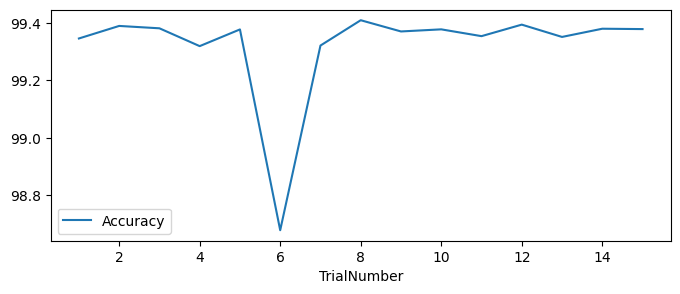

In [6]:
%matplotlib inline
ResultsData.plot(x='TrialNumber', y='Accuracy', figsize=(8,3), kind='line')

In [7]:
max_val_ac = ResultsData.loc[ResultsData['Accuracy'] == ResultsData['Accuracy'].max()].values

eph = max_val_ac[0][4]
b_size = max_val_ac[0][1]
print(eph, b_size)

100 10


In [8]:
# Fitting the ANN to the Training set

X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])

model = Sequential()
# Defining the first layer of the model
model.add(Dense(units=8, input_dim=8, kernel_initializer='normal', activation='relu'))

# Defining the First hidden layer of the model
model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))

# Defining the second hidden layer of the model
model.add(Dense(units=1, kernel_initializer='normal'))

# Defining the Third hidden layer of the model
model.add(Dense(units=7, kernel_initializer='normal', activation='relu'))

# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the ANN to the Training set and validating on the validation set
history = model.fit(X_train, y_train ,batch_size = b_size, epochs =eph, verbose=0)

In [9]:
# Generating Predictions on traning data
Predictions_train=model.predict(X_train)

# Scaling the predicted rings data back to original rings scale
Predictions_train=TargetVarScalerFit.inverse_transform(Predictions_train)

# Scaling the y_test Price data back to original rings scale
y_train_orig=TargetVarScalerFit.inverse_transform(y_train)

# Scaling the test data back to original scale
Train_Data=PredictorScalerFit.inverse_transform(X_train)

118/118 [==============================] - 0s 1ms/step


In [10]:
TrainingData=pd.DataFrame(data=Train_Data, columns=Predictors)
TrainingData['Rings']=y_train_orig

Train_Data_round=np.round(Predictions_train)
TrainingData['PredictedRings']=Train_Data_round

In [11]:
TrainingData.head()

Sex  Length  Diameter  Height  Whole weight  Shucked weight  \
0  1.0   0.650     0.525    0.19        1.4995          0.6265   
1  2.0   0.550     0.450    0.14        0.7530          0.3445   
2  1.0   0.570     0.455    0.15        0.9520          0.3895   
3  1.0   0.645     0.500    0.16        1.3815          0.6720   
4  2.0   0.435     0.340    0.11        0.4070          0.1685   

   Viscera weight  Shell weight  Rings  PredictedRings  
0          0.4005        0.3950   14.0            11.0  
1          0.1325        0.2400    8.0            10.0  
2          0.2155        0.2745    9.0            11.0  
3          0.3260        0.3150    9.0             9.0  
4          0.0730        0.1300   10.0             8.0

In [12]:
# Generating Predictions on testing data
Predictions=model.predict(X_test)

# Scaling the predicted rings data back to original rings scale
Predictions=TargetVarScalerFit.inverse_transform(Predictions)

# Scaling the y_test Price data back to original rings scale
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)

# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)

14/14 [==============================] - 0s 2ms/step


In [13]:
TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['Rings']=y_test_orig

Test_Data_round=np.round(Predictions)
TestingData['PredictedRings']=Test_Data_round

In [14]:
TestingData.head()

Sex  Length  Diameter  Height  Whole weight  Shucked weight  \
0  2.0   0.315     0.235   0.070        0.1490          0.0580   
1  1.0   0.615     0.500   0.170        1.0540          0.4845   
2  2.0   0.465     0.370   0.120        0.4365          0.1880   
3  0.0   0.565     0.450   0.165        0.8870          0.3700   
4  2.0   0.390     0.290   0.090        0.2745          0.1350   

   Viscera weight  Shell weight  Rings  PredictedRings  
0          0.0325         0.047    7.0             6.0  
1          0.2280         0.295   10.0            11.0  
2          0.0815         0.147    9.0             9.0  
3          0.2390         0.249   11.0            10.0  
4          0.0455         0.078    8.0             7.0

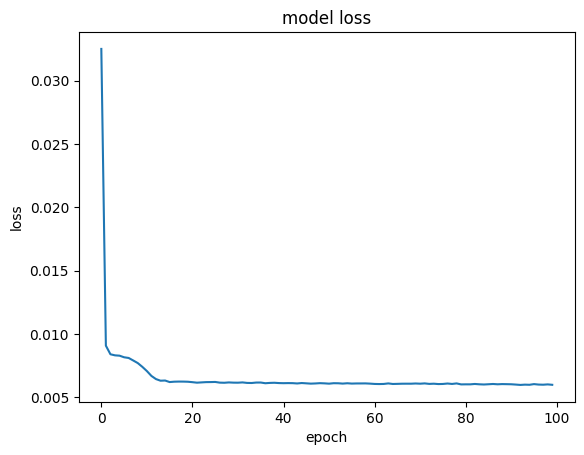

In [18]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# calculate the Mean Squared Error(MSE) for the training and test sets
train_mse = mean_squared_error(TrainingData['Rings'],TrainingData['PredictedRings'])
test_mse = mean_squared_error(TestingData['Rings'],TestingData['PredictedRings'])

# Calculate the root mean squared error (RMSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# calculate the coefficient of determination (R squared) for the training and test sets
train_r2 = r2_score(TrainingData['Rings'],TrainingData['PredictedRings'])
test_r2 = r2_score(TestingData['Rings'],TestingData['PredictedRings'])

# print the evaluation metrics
print('Train MSE: {:.3f}'.format(train_mse))
print('Test MSE: {:.3f}'.format(test_mse))
print('Train RMSE: {:.3f}'.format(train_rmse))
print('Test RMSE: {:.3f}'.format(test_rmse))
print('Train R^2: {:.3f}'.format(train_r2))
print('Test R^2: {:.3f}'.format(test_r2))


Train MSE: 4.751
Test MSE: 4.962
Train RMSE: 2.180
Test RMSE: 2.227
Train R^2: 0.544
Test R^2: 0.515


In [17]:
# Computing the Absolute Percent Error(APE) for training set
Train_APE = 100 *(abs(TrainingData['Rings']-TrainingData['PredictedRings'])/TrainingData['Rings'])

# Computing the Absolute Percent Error(APE)for testing set
Test_APE=100*(abs(TestingData['Rings']-TestingData['PredictedRings'])/TestingData['Rings'])

print("The accuracy of the ANN (training test) model is:",100-np.mean(Train_APE))
print('The Accuracy of ANN model(testing set) is:', 100-np.mean(Test_APE))


The accuracy of the ANN (training test) model is: 85.3893789028214
The Accuracy of ANN model(testing set) is: 84.8203839125787


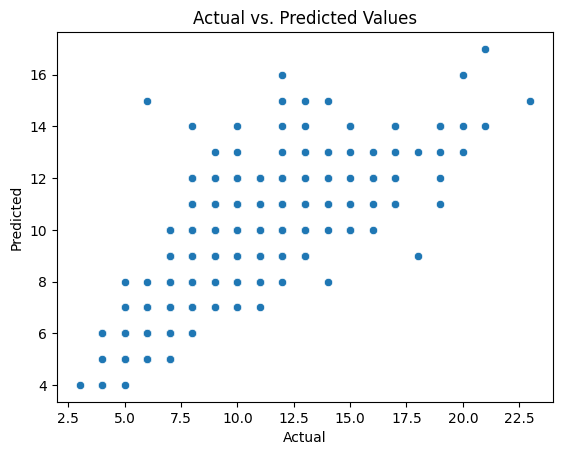

In [19]:
# Plotting the actual vs. predicted values
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the actual vs. predicted values
sns.scatterplot(data=TestingData, x='Rings', y='PredictedRings')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()

In [20]:
correlation = np.corrcoef(TestingData['Rings'],TestingData['PredictedRings'])[0, 1]
print(correlation)

0.7230908554538448
